## Bayesian Correlation with PyMC3

In this notebook, I show how to determine a correlation coefficient within the Bayesian framework both in a simply and a robust way. The correlation can be seen as a direct alternative to the traditional Pearson correlation coefficient.

The original implementation for PyMC2 is available at http://www.philippsinger.info/?p=581

The model and code shown here is motivated by the following blog posts and the book "Bayesian Cognitive Modeling":

* http://www.sumsar.net/blog/2013/08/bayesian-estimation-of-correlation/
* http://www.sumsar.net/blog/2013/08/robust-bayesian-estimation-of-correlation/
* http://bayesmodels.com/

My main contribution here is to show how do apply the model with Python and PyMC.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 

### Model

First, let us start with defining our model both for the classic way of using a multivariate normal distribution as well as for the robust way that utilizes a multivariate student t-distribution.

In [2]:
import pymc3 as pm
import numpy as np
import theano.tensor as T

In [3]:
def precision(sigma, rho):
    C = T.alloc(rho, 2, 2)
    C = T.fill_diagonal(C, 1.)
    S = T.diag(sigma)
    return T.nlinalg.matrix_inverse(T.nlinalg.matrix_dot(S, C, S))


def analyze(data):
    with pm.Model() as model:
        # priors might be adapted here to be less flat
        mu = pm.Normal('mu', mu=0., sd=0.000001, shape=2, testval=np.mean(data, axis=1))
        sigma = pm.Uniform('sigma', lower=1e-6, upper=1000., shape=2, testval=np.std(data, axis=1))
        rho = pm.Uniform('r', lower=-1., upper=1., testval=0)

        prec = pm.Deterministic('prec', precision(sigma, rho))
        mult_n = pm.MvNormal('mult_n', mu=mu, tau=prec, observed=data.T)

    return model

### Data

Let us define some data.

In [4]:
x = np.array([525., 300., 450., 300., 400., 500., 550., 125., 300., 400., 500., 550.])
y = np.array([250., 225., 275., 350., 325., 375., 450., 400., 500., 550., 600., 525.])
data = np.array([x, y])

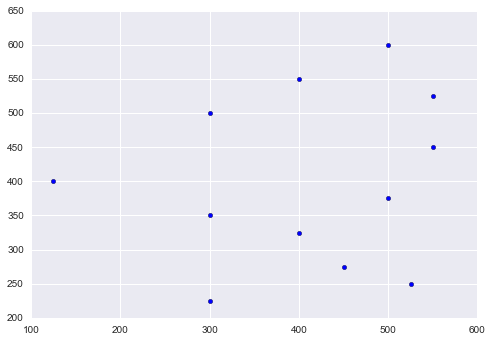

In [5]:
plt.scatter(x, y)

### Inference

And now, we can do the inference. First, with the classic (non-robust) model.

In [6]:
model = analyze(data)
with model:
    trace = pm.sample(50000, tune=25000, step=pm.Metropolis())

100%|██████████| 50000/50000 [00:35<00:00, 1400.39it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f260cbe5dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f260993d828>]], dtype=object)

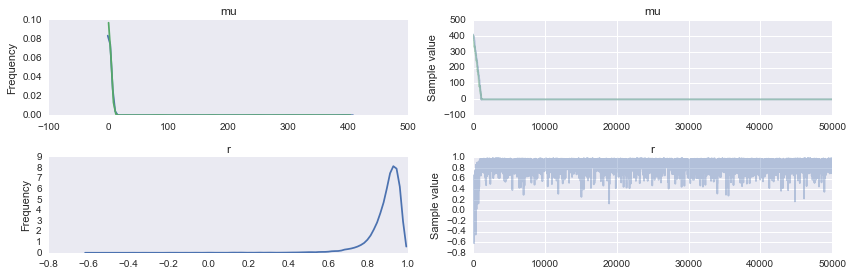

In [7]:
pm.traceplot(trace, varnames=['mu', 'r'])